In [1]:
import numpy as np 
import pandas as pd
import jax.numpy as jnp 
import matplotlib.pylab as plt  
from getdist import plots, MCSamples
from utils.helpers import pickle_load

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
color1 = '#50C878' #'#B5CA8D'
color3 = '#222E50'
alpha = 0.9
palefactor = 0.9
linewidth = 2 
contours = [0.68,0.95]

In [2]:
def triangle_plot(mcmc_samples, labels, subplot_size = 2, font_size = 18, fname = None):
    ndim = len(labels)
    colour = 'green'
    names = ["x%s"%i for i in range(ndim)]
    samples = MCSamples(samples=mcmc_samples,names = names, labels = labels, settings = settings)
    
    G = plots.getSubplotPlotter(subplot_size=subplot_size)
    samples.updateSettings({'contours': contours})
    G.settings.solid_contour_palefactor = 0.9
    G.settings.alpha_filled_add = 0.6
    G.settings.num_plot_contours = 2
    G.triangle_plot(samples, filled = True, line_args={'lw':linewidth, 'color':colour}, contour_colors=[colour])
    
    for i in range(0,ndim):
        for j in range(0, i+1):
            if i != j:
                ax = G.subplots[i,j]

                a, b = G.get_param_array(samples, ['x'+str(j), 'x'+str(i)])
                density = G.sample_analyser.get_density_grid(samples, a, b)
                density.contours = density.getContourLevels(contours)
                contour_levels = density.contours

                ax.contour(density.x, density.y, density.P, sorted(contour_levels), colors = colour, linewidths = linewidth) 
                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
            else:
                ax = G.subplots[i,j]   

                dense = samples.get1DDensity('x'+str(i))
                dense.normalize(by='max')
                ax.plot(dense.x, dense.P, lw = linewidth+2, c = colour)

                ax.tick_params(axis = 'x', labelsize = font_size, rotation=45, pad=5)
                ax.tick_params(axis = 'y', labelsize = font_size, pad=5)
                ax.yaxis.label.set_size(font_size)
                ax.xaxis.label.set_size(font_size)
                ax.xaxis.labelpad = 20
                ax.yaxis.labelpad = 20
    # if fname is not None:
    #     os.makedirs('plots', exist_ok=True)
    #     plt.savefig(f'plots/triangle_plot_{fname}.pdf', bbox_inches = 'tight')
    # plt.close()
    plt.show()

In [3]:
colnames = ['weight', 'minuslogpost', 
            'sigma8', 'omegac', 'omegab', 'hubble', 'ns',
            'm1', 'm2', 'm3', 'm4',
            'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
            'a_ia', 'eta',
            'b1', 'b2', 'b3', 'b4', 'b5',
            'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5',
            'minuslogprior', 'minuslogprior__0', 'chi2',  'chi2__my_likelihood']

params = ['sigma8', 'omegac', 'omegab', 'hubble', 'ns',
            'm1', 'm2', 'm3', 'm4',
            'dz_wl_1', 'dz_wl_2', 'dz_wl_3', 'dz_wl_4',
            'a_ia', 'eta',
            'b1', 'b2', 'b3', 'b4', 'b5',
            'dz_gc_1', 'dz_gc_2', 'dz_gc_3', 'dz_gc_4', 'dz_gc_5']

In [41]:
samples = np.loadtxt('outputcobaya/testing/jaxcosmo_1/output_prefix.1.txt')

In [42]:
dataframe = pd.DataFrame(samples, columns=colnames)
# dataframe.to_csv('/home/arrykrishna/Desktop/test.csv')

In [43]:
dataframe.head()

,weight,minuslogpost,sigma8,omegac,omegab,hubble,ns,m1,m2,m3,...,b5,dz_gc_1,dz_gc_2,dz_gc_3,dz_gc_4,dz_gc_5,minuslogprior,minuslogprior__0,chi2,chi2__my_likelihood
0,1.0,91.807162,0.850461,0.266152,0.038462,0.701991,0.992415,0.011773,0.012631,0.012922,...,1.882075,0.020869,0.000752,0.017729,0.009274,-0.010889,-36.889290,-36.889290,257.39290,257.39290
1,1.0,90.539798,0.849177,0.264482,0.038614,0.702321,0.992472,0.011151,0.012277,0.013948,...,1.882374,0.020823,0.000102,0.016481,0.007768,-0.012206,-37.473904,-37.473904,256.02740,256.02740
2,1.0,91.474040,0.849068,0.264608,0.038505,0.702340,0.992004,0.011257,0.011991,0.014453,...,1.881689,0.021898,-0.000051,0.016751,0.008208,-0.012455,-36.815678,-36.815678,256.57944,256.57944
3,1.0,91.505793,0.849040,0.264650,0.038501,0.702331,0.991992,0.011235,0.011972,0.014450,...,1.881719,0.021901,-0.000037,0.016738,0.008176,-0.012440,-36.824376,-36.824376,256.66034,256.66034
4,1.0,91.507974,0.849039,0.264651,0.038502,0.702331,0.991994,0.011235,0.011974,0.014450,...,1.881720,0.021900,-0.000036,0.016740,0.008176,-0.012441,-36.823765,-36.823765,256.66348,256.66348


In [44]:
samples.shape

(78062, 31)

In [45]:
min(samples[:,-1])

180.34164

In [46]:
nsamples = 15000
thinfactor = samples.shape[0] // nsamples
samples_thinned = samples[-thinfactor * nsamples::thinfactor]

## Triangle Plot

In [47]:
labels = [r'$\sigma_{8}$', r'$\Omega_{c}$', r'$\Omega_{b}$', r'$h$', r'$n_{s}$',
          r'$m_{1}$', r'$m_{2}$', r'$m_{3}$', r'$m_{4}$', 
          r'$\delta z_{1}^{(s)}$', r'$\delta z_{2}^{(s)}$', r'$\delta z_{3}^{(s)}$', r'$\delta z_{4}^{(s)}$',
          r'$A_{IA}$', r'$\eta$', r'$b_{1}$', r'$b_{2}$', r'$b_{3}$', r'$b_{4}$', r'$b_{5}$',
         r'$\delta z_{1}^{(g)}$', r'$\delta z_{2}^{(g)}$', r'$\delta z_{3}^{(g)}$', r'$\delta z_{4}^{(g)}$', r'$\delta z_{5}^{(g)}$']

In [48]:
labels_cosmo = labels[0:5]
labels_multiplicative = labels[5:9]
labels_shift_shear = labels[9:13]
labels_intrinsic = labels[13:15]
labels_bias = labels[15:20]
labels_shift_galaxy = labels[20:]

Removed no burn in


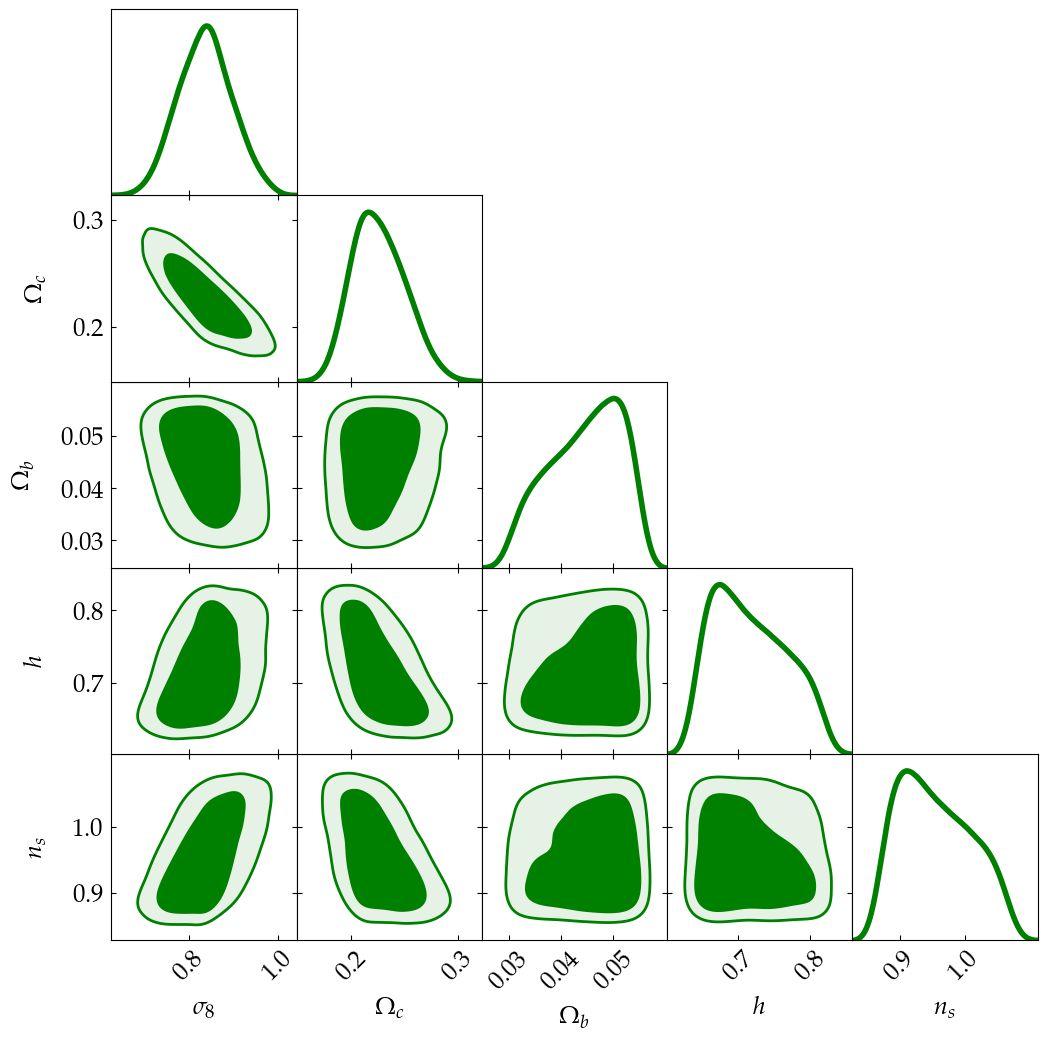

In [49]:
triangle_plot(samples_thinned[:,2:7], labels_cosmo)